In [7]:
#Data
import pandas as pd
#System
from os import walk
#Music Analysis
import music21 as m21

#Maths
import numpy as np
import itertools as it
import random as rd

#Encodage
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import re

m21.environment.set('musescoreDirectPNGPath', '/home/homer/Programmes/MuseScore-3.5.0-x86_64.AppImage')

In [8]:
dirPath = "data/midiclassics/Bach"
midiPiece = "Bwv0526 Sonate en trio n2.mid"
midiPath = dirPath + "/" + midiPiece

## Données sous forme de mots

In [1]:
def transposeMidi(midi, key) :
    k = midi.analyze('key')
    i = m21.interval.Interval(k.tonic, m21.pitch.Pitch(key))
    midiNew = midi.transpose(i)
    return midiNew

def chord2word(thisChord, durations=True) :
    #retourne un mot à partir d'un accord
    word = "_"
    for note in thisChord :
        word+=note.name+str(note.octave)+"°"+str(note.duration)[27:-1]+"_"
    return word
        
def midi2sentence(midiPath, transpose = False) :
    #retourne une phrase à partir d'un morceau
    
    midiTemp = m21.converter.parse(midiPath)
    
    #transposition
    if transpose :
        midi = transposeMidi(midiTemp, transpose)
    else :
        midi = midiTemp
        
    sentence = ""
    
    dictPitch = {}
    for element in midi.recurse() :
        if isinstance(element, m21.note.Note) :
            if element.offset in dictPitch :
                dictPitch[element.offset].append(element)
            else :
                dictPitch[element.offset]=[element]
        if isinstance(element, m21.chord.Chord) :
            for note in element :
                if element.offset in dictPitch :
                    dictPitch[element.offset].append(element)
                else :
                    dictPitch[element.offset]=[element]
        """if isinstance(element, m21.note.Rest) :
            if element.offset in dictPitch :
                dictPitch[element.offset].append(element)
            else :
                dictPitch[element.offset]=[element]"""
    
    for offset in sorted(dictPitch) :
        thisChord = m21.chord.Chord(dictPitch[offset])
        word = chord2word(thisChord)
        sentence+=word+" "
    
    return sentence

def sentence2midi(sentence) :
    s = m21.stream.Stream()
    for wordTemp in sentence.split(" ") :
        word = ""
        d = m21.duration.Duration(2.0)
        for letter in wordTemp.split(".") :
            word+=letter+" "
        thisChord=m21.chord.Chord(word[:-1], duration = d)
        s.append(thisChord)
    return s
            
    
def token2sentence(token) :
    sentence=""
    for word in sentence :
        sentence+=word+"."
    return sentence
    

def sentenceEncoding(sentence, order = "character") :
    #retourne encodage one hot de la phrase, integer encode de la phrase et la taille du vocabulaire
    #Ordre = chara ou word
    if order == "character" :
        token = sentence.split(".")
    elif order == "word" :
        token = sentence.split(" ")
        #A finir
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(token)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    vocabLength = int(max(integer_encoded))
    return onehot_encoded, integer_encoded, vocabLength
    

    

In [10]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

def word2chord(word, duration = True) :
    if "Start" in word :
        word = word[6:-1]
    elif "End" in word : 
        if len(word)==3 :
            return False
        word = word[1:-3]
    else :
        word = word[1:-1]
        
    chordTemp = []
    for letter in word.split("_") :
        noteTemp, durationTemp = letter.split("°")
        duration = m21.duration.Duration(convert_to_float(durationTemp))
        note = m21.note.Note(noteTemp, duration = duration)
        chordTemp.append(note)
    chord = m21.chord.Chord(chordTemp)
    return chord

def token2midi(token):
    s = m21.stream.Stream()
    flag = False
    i=0
    while i <len(token) :
        chordTemp = []
        while token[i] != " " and not("Start" in token[i]) and not("End" in token[i]) and i <len(token)-1 :
            word = token[i]
            flag = True
            noteTemp, durationTemp = word.split("°")
            duration = m21.duration.Duration(convert_to_float(durationTemp))
            note = m21.note.Note(noteTemp, duration = duration)
            chordTemp.append(note)
            i+=1
        if flag :
            chord = m21.chord.Chord(chordTemp)
            s.append(chord)
            flag = False
        i+=1
            
    return s

def sentence2midi(sentence) :
    s = m21.stream.Stream()
    for wordTemp in sentence.split(" ")[5:-5] :
        thisChord = word2chord(wordTemp)
        if thisChord :#On vérifie que l'accord n'est pas vide
            s.append(thisChord)
    return s

def token2sentence(token, order="character", sepTime = False) :
    sentence=""
    if order == "character" :
        if sepTime :
            
                if "Start" in word :
                    sentence+=word+"_"
                elif "." in word : # C'est une durée
                    sentence+="°"+word+"_"
                elif " " in word:# C'est un espace
                    sentence+=word+"_"
                else :
                    sentence+=word
        else :
            for word in token :
                sentence+=word+"_"
        return sentence[:-1]
    elif order == "word" :
        for word in token :
            sentence+=word+" "
    return sentence[:-1]

In [16]:
sentence = midi2sentence(midiPath)
stream = sentence2midi(sentence)

## Données matricielles

In [102]:
def midi2matrix(midiPath) :
    midi = m21.converter.parse(midiPath)
    notes = midi.recurse()
    pieceLength = int(notes[-1].offset*4)+4
    matrix = np.zeros((127, pieceLength))
    for element in midi.recurse() :
        if isinstance(element, m21.note.Note) :
            note_y = element.pitch.midi
            note_x = int(element.offset*4)
            noteValue = int(float(str(elm.duration)[27:-1])*4)
            matrix[note_y, note_x]=noteValue
        if isinstance(element, m21.chord.Chord) :
            for note in element :
                if isinstance(element, m21.note.Note) :
                    note_y = element.pitch.midi
                    note_x = int(element.offset*4)
                    noteValue = int(float(str(elm.duration)[27:-1])*4)
                    matrix[note_y, note_x]=noteValue   
    return matrix, pieceLength

def oneHotMatrix(matrix) :
    matLength = len(matrix[0])
    oneHotDict = {}
    oneHotArray = []
    i=0
    for vec in matrix.T :#On observe la matrice colonne par colonne
        if not(tuple(vec) in oneHotDict) :
            oneHotDict[tuple(vec)]=i
            i+=1
            
    for vec in matrix.T :
        oneHotArray.append(oneHotDict[tuple(vec)])
        
    return oneHotArray, len(oneHotArray)
    
        
    

def matrix2midi(matrix):
    
    return

## Base de données

In [103]:
def musicDataBase(artists, myDirectory, transpose = False) :
    print("Creating the musical data base...\n")
    dictArtist = {}
    i=0      #key of dict = index in df
    
    #Progress bar
    length = 0
    for (directory, subdirectory, files) in walk(myDirectory):
        for artist in artists :
            if artist in directory :
                length+=len(files)
    ind = 1      #number of file explored
    print("/!\ : " +str(length)+" files are going to be reducted in the dataFrame, this might take a bit of time...\n")
       
    for artist in artists :
        print("## ------ " + artist + " pieces are loading... ----- ##\n")
        for (directory, subdirectory, files) in walk(myDirectory):
            for file in files :
                if artist in directory :
                    ind+=1
                    if file[0]!="." :
                        print("loading " + file + "... " + str(ind/length*100) + "%")
                        try:
                            sentence = midi2sentence(directory+"/"+file, transpose = transpose)
                            dictArtist[i]=[artist, file, sentence]
                            i+=1
                        except Exception as e:
                            print("Error on {0}".format(file), e)
                            print("\n")
        
    print("Success !")
    return pd.DataFrame(dictArtist, index = ["Artist", "File", "Piece"]).T

In [104]:
artists = ["Bach", "Mozart", "Chopin", "Schubert", "Beethoven", "Haydn"]
myDirectory = "midiclassics"
db = musicDataBase(["Test2"], myDirectory, "C")
db.to_pickle("keithKoln.pkl")

Creating the musical data base...

/!\ : 2 files are going to be reducted in the dataFrame, this might take a bit of time...

## ------ Test2 pieces are loading... ----- ##

loading keithkoln.mid... 150.0%
Success !


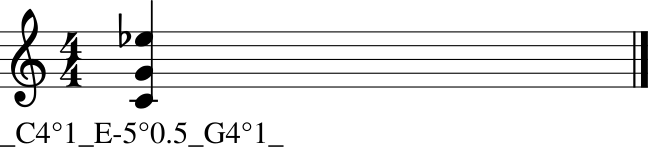

In [12]:
s = m21.stream.Stream()
c4 = m21.note.Note("C4", duration = m21.duration.Duration(1))
eb5 = m21.note.Note("E-5", duration = m21.duration.Duration(0.5))
g4 = m21.note.Note("G4", duration = m21.duration.Duration(1))
chord1 = m21.chord.Chord([c4, eb5, g4])
s.append(chord1)
s[0].addLyric("_C4°1_E-5°0.5_G4°1_")
s.show()

AttributeError: 'DataFrame' object has no attribute '_data'

In [35]:
testset = set()

In [36]:
testset.add('bcd')
testset.add('abd')

In [37]:
list(testset)

['abd', 'bcd']